In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

# deepOF model evaluation

Given a dataset and a trained model, this notebook allows the user to 

* Load and inspect the different models (encoder, decoder, grouper, gmvaep)
* Visualize reconstruction quality for a given model
* Visualize a static latent space
* Visualize trajectories on the latent space for a given video
* sample from the latent space distributions and generate video clips showcasing generated data

In [3]:
import os

os.chdir(os.path.dirname("../"))

In [4]:
import deepof.data
import deepof.utils
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from collections import Counter
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import umap

from ipywidgets import interactive, interact, HBox, Layout, VBox
from IPython import display
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import interact

### 1. Define and run project

In [33]:
path = os.path.join("..", "..", "Desktop", "deepof-data", "deepof_single_topview")
trained_network = os.path.join("..", "..", "Desktop")
exclude_bodyparts = tuple([""])
window_size = 24

In [34]:
%%time
proj = deepof.data.project(
    path=path, smooth_alpha=0.999, exclude_bodyparts=exclude_bodyparts, arena_dims=[380],
)

CPU times: user 41.7 s, sys: 3.12 s, total: 44.8 s
Wall time: 37.5 s


In [35]:
%%time
proj = proj.run(verbose=True)
print(proj)

Loading trajectories...
Smoothing trajectories...
Interpolating outliers...
Iterative imputation of ocluded bodyparts...
Computing distances...
Computing angles...
Done!
deepof analysis of 166 videos
CPU times: user 12min 42s, sys: 25.4 s, total: 13min 8s
Wall time: 3min 4s


### 2. Load pretrained deepof model

In [36]:
coords = proj.get_coords(center="Center", align="Spine_1", align_inplace=True)
data_prep = coords.preprocess(test_videos=0, window_step=1, window_size=window_size, shuffle=False)[
    0
]

In [38]:
[i for i in os.listdir(trained_network) if i.endswith("h5")]

['GMVAE_input_type=coords_NextSeqPred=0.15_PhenoPred=0.0_RuleBasedPred=0.0_loss=ELBO_encoding=6_k=15_latreg=none_entknn=100_run=3_final_weights.h5',
 'GMVAE_input_type=coords_NextSeqPred=0.0_PhenoPred=0.0_RuleBasedPred=0.15_loss=ELBO_encoding=6_k=15_latreg=none_entknn=100_run=2_final_weights.h5',
 'GMVAE_input_type=coords_NextSeqPred=0.0_PhenoPred=0.0_RuleBasedPred=0.15_loss=ELBO_encoding=6_k=15_latreg=none_entknn=100_run=9_final_weights.h5',
 'GMVAE_input_type=coords_NextSeqPred=0.0_PhenoPred=0.0_RuleBasedPred=0.15_loss=ELBO_encoding=6_k=15_latreg=none_entknn=100_run=3_final_weights.h5',
 'GMVAE_input_type=coords_NextSeqPred=0.15_PhenoPred=0.0_RuleBasedPred=0.0_loss=ELBO_encoding=6_k=15_latreg=none_entknn=100_run=2_final_weights.h5',
 'GMVAE_input_type=coords_NextSeqPred=0.15_PhenoPred=0.0_RuleBasedPred=0.0_loss=ELBO_encoding=6_k=15_latreg=none_entknn=100_run=9_final_weights.h5',
 'GMVAE_input_type=coords_NextSeqPred=0.0_PhenoPred=0.0_RuleBasedPred=0.15_loss=ELBO_encoding=6_k=15_latre

In [39]:
deepof_weights = [i for i in os.listdir(trained_network) if i.endswith("h5")][8]
deepof_weights

'GMVAE_input_type=coords_NextSeqPred=0.0_PhenoPred=0.0_RuleBasedPred=0.0_loss=ELBO_encoding=6_k=15_latreg=none_entknn=100_run=8_final_weights.h5'

In [42]:
# Set model parameters
encoding = int(re.findall("encoding=(\d+)_", deepof_weights)[0])
k = int(re.findall("k=(\d+)_", deepof_weights)[0])
loss = re.findall("loss=(.+?)_", deepof_weights)[0]
pheno = 0
predictor = 0

In [43]:
(
    encode_to_vector,
    decoder,
    grouper,
    gmvaep,
    prior,
    posterior,
) = deepof.models.SEQ_2_SEQ_GMVAE(
    loss=loss,
    number_of_components=k,
    compile_model=True,
    encoding=encoding,
    next_sequence_prediction=predictor,
    phenotype_prediction=pheno,
).build(
    data_prep.shape
)

gmvaep.load_weights(os.path.join(trained_network, deepof_weights))

In [44]:
# Uncomment to see model summaries
# encoder.summary()
# decoder.summary()
# grouper.summary()
# gmvaep.summary()

In [45]:
# Uncomment to plot model structure
def plot_model(model, name):
    tf.keras.utils.plot_model(
        model,
        to_file=os.path.join(
            path,
            "deepof_{}_{}.png".format(name, datetime.now().strftime("%Y%m%d-%H%M%S")),
        ),
        show_shapes=True,
        show_dtype=False,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=True,
        dpi=200,
    )


# plot_model(encoder, "encoder")
# plot_model(decoder, "decoder")
# plot_model(grouper, "grouper")
# plot_model(gmvaep, "gmvaep")

### 4. Evaluate reconstruction (to be incorporated into deepof.evaluate)

In [46]:
# Auxiliary animation functions


def plot_mouse_graph(instant_x, instant_y, instant_rec_x, instant_rec_y, ax, edges):
    """Generates a graph plot of the mouse"""
    plots = []
    rec_plots = []
    for edge in edges:
        (temp_plot,) = ax.plot(
            [float(instant_x[edge[0]]), float(instant_x[edge[1]])],
            [float(instant_y[edge[0]]), float(instant_y[edge[1]])],
            color="#006699",
            linewidth=2.0,
        )
        (temp_rec_plot,) = ax.plot(
            [float(instant_rec_x[edge[0]]), float(instant_rec_x[edge[1]])],
            [float(instant_rec_y[edge[0]]), float(instant_rec_y[edge[1]])],
            color="red",
            linewidth=2.0,
        )
        plots.append(temp_plot)
        rec_plots.append(temp_rec_plot)
    return plots, rec_plots


def update_mouse_graph(x, y, rec_x, rec_y, plots, rec_plots, edges):
    """Updates the graph plot to enable animation"""

    for plot, edge in zip(plots, edges):
        plot.set_data(
            [float(x[edge[0]]), float(x[edge[1]])],
            [float(y[edge[0]]), float(y[edge[1]])],
        )
    for plot, edge in zip(rec_plots, edges):
        plot.set_data(
            [float(rec_x[edge[0]]), float(rec_x[edge[1]])],
            [float(rec_y[edge[0]]), float(rec_y[edge[1]])],
        )

In [47]:
# Display a video with the original data superimposed with the reconstructions

coords = proj.get_coords(center="Center", align="Spine_1", align_inplace=True)
random_exp = np.random.choice(list(coords.keys()), 1)[0]
print(random_exp)


def animate_mice_across_time(random_exp):

    # Define canvas
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Retrieve body graph
    edges = deepof.utils.connect_mouse_topview()

    for bpart in exclude_bodyparts:
        if bpart:
            edges.remove_node(bpart)

    for limb in ["Left_fhip", "Right_fhip", "Left_bhip", "Right_bhip"]:
        edges.remove_edge("Center", limb)
        if ("Tail_base", limb) in edges.edges():
            edges.remove_edge("Tail_base", limb)

    edges = edges.edges()

    # Compute observed and predicted data to plot
    data = coords[random_exp]
    coords_rec = coords.filter_videos([random_exp])
    data_prep = coords_rec.preprocess(
        test_videos=0, window_step=1, window_size=window_size, shuffle=False
    )[0]

    data_rec = gmvaep.predict(data_prep)
    try:
        data_rec = pd.DataFrame(coords_rec._scaler.inverse_transform(data_rec[:, 6, :]))
    except TypeError:
        data_rec = data_rec[0]
        data_rec = pd.DataFrame(coords_rec._scaler.inverse_transform(data_rec[:, 6, :]))
        
    data_rec.columns = data.columns
    data = pd.DataFrame(coords_rec._scaler.inverse_transform(data_prep[:, 6, :]))
    data.columns = data_rec.columns

    # Add Central coordinate, lost during alignment
    data["Center", "x"] = 0
    data["Center", "y"] = 0
    data_rec["Center", "x"] = 0
    data_rec["Center", "y"] = 0

    # Plot!
    init_x = data.xs("x", level=1, axis=1, drop_level=False).iloc[0, :]
    init_y = data.xs("y", level=1, axis=1, drop_level=False).iloc[0, :]
    init_rec_x = data_rec.xs("x", level=1, axis=1, drop_level=False).iloc[0, :]
    init_rec_y = data_rec.xs("y", level=1, axis=1, drop_level=False).iloc[0, :]

    plots, rec_plots = plot_mouse_graph(
        init_x, init_y, init_rec_x, init_rec_y, ax, edges
    )
    scatter = ax.scatter(
        x=np.array(init_x), y=np.array(init_y), color="#006699", label="Original"
    )
    rec_scatter = ax.scatter(
        x=np.array(init_rec_x),
        y=np.array(init_rec_y),
        color="red",
        label="Reconstruction",
    )

    # Update data in main plot
    def animation_frame(i):
        # Update scatter plot
        x = data.xs("x", level=1, axis=1, drop_level=False).iloc[i, :]
        y = data.xs("y", level=1, axis=1, drop_level=False).iloc[i, :]
        rec_x = data_rec.xs("x", level=1, axis=1, drop_level=False).iloc[i, :]
        rec_y = data_rec.xs("y", level=1, axis=1, drop_level=False).iloc[i, :]

        scatter.set_offsets(np.c_[np.array(x), np.array(y)])
        rec_scatter.set_offsets(np.c_[np.array(rec_x), np.array(rec_y)])
        update_mouse_graph(x, y, rec_x, rec_y, plots, rec_plots, edges)

        return scatter

    animation = FuncAnimation(fig, func=animation_frame, frames=250, interval=50,)

    ax.set_title("Original versus reconstructed data")
    ax.set_ylim(-100, 60)
    ax.set_xlim(-60, 60)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.legend()

    video = animation.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()


animate_mice_across_time(random_exp)

Test 57_s41


### 5. Evaluate latent space (to be incorporated into deepof.evaluate)

In [48]:
# Get encodings and groupings for the same random video as above
data_prep = coords.preprocess(
    test_videos=0, window_step=1, window_size=window_size, shuffle=False
)[0]

encodings = encode_to_vector.predict(data_prep)
groupings = grouper.predict(data_prep)
hard_groups = np.argmax(groupings, axis=1)

KeyboardInterrupt: 

In [ ]:
@interact(minimum_confidence=(0.0, 1.0, 0.01))
def plot_cluster_population(minimum_confidence):
    plt.figure(figsize=(12, 8))

    groups = hard_groups[np.max(groupings, axis=1) > minimum_confidence].flatten()
    groups = np.concatenate([groups, np.arange(25)])
    sns.countplot(groups)
    plt.xlabel("Cluster")
    plt.title("Training instances per cluster")
    plt.ylim(0, hard_groups.shape[0] * 1.1)
    plt.show()

The slider in the figure above lets you set the minimum confidence the model may yield when assigning a training instance to a cluster in order to be visualized.

In [28]:
# Plot real data in the latent space

samples = np.random.choice(range(encodings.shape[0]), 10000)
sample_enc = encodings[samples, :]
sample_grp = groupings[samples, :]
sample_hgr = hard_groups[samples]
k = sample_grp.shape[1]

umap_reducer = umap.UMAP(n_components=2)
pca_reducer = PCA(n_components=2)
tsne_reducer = TSNE(n_components=2)
lda_reducer = LinearDiscriminantAnalysis(n_components=2)

umap_enc = umap_reducer.fit_transform(sample_enc)
pca_enc = pca_reducer.fit_transform(sample_enc)
tsne_enc = tsne_reducer.fit_transform(sample_enc)
try:
    lda_enc = lda_reducer.fit_transform(sample_enc, sample_hgr)
except ValueError:
    warnings.warn(
        "Only one class found. Can't use LDA", DeprecationWarning, stacklevel=2
    )


@interact(
    minimum_confidence=(0.0, 0.99, 0.01),
    dim_red=["PCA", "LDA", "umap", "tSNE"],
    highlight_clusters=False,
    selected_cluster=(0, k-1),
)
def plot_static_latent_space(
    minimum_confidence, dim_red, highlight_clusters, selected_cluster
):

    global sample_enc, sample_grp, sample_hgr

    if dim_red == "umap":
        enc = umap_enc
    elif dim_red == "LDA":
        enc = lda_enc
    elif dim_red == "PCA":
        enc = pca_enc
    else:
        enc = tsne_enc

    enc = enc[np.max(sample_grp, axis=1) > minimum_confidence]
    hgr = sample_hgr[np.max(sample_grp, axis=1) > minimum_confidence].flatten()
    grp = sample_grp[np.max(sample_grp, axis=1) > minimum_confidence]

    plt.figure(figsize=(12, 8))

    sns.scatterplot(
        x=enc[:, 0],
        y=enc[:, 1],
        hue=hgr,
        size=np.max(grp, axis=1),
        sizes=(1, 100),
        palette=sns.color_palette("husl", len(set(hgr))),
    )
    
    if highlight_clusters:
        sns.kdeplot(
            enc[hgr == selected_cluster, 0],
            enc[hgr == selected_cluster, 1],
            color="red",
        )
    
    plt.xlabel("{} 1".format(dim_red))
    plt.ylabel("{} 2".format(dim_red))
    plt.suptitle("Static view of trained latent space")
    plt.show()

interactive(children=(FloatSlider(value=0.49, description='minimum_confidence', max=0.99, step=0.01), Dropdown…

In [29]:
def plot_mouse_graph(instant_x, instant_y, ax, edges):
    """Generates a graph plot of the mouse"""
    plots = []
    for edge in edges:
        (temp_plot,) = ax.plot(
            [float(instant_x[edge[0]]), float(instant_x[edge[1]])],
            [float(instant_y[edge[0]]), float(instant_y[edge[1]])],
            color="#006699",
            linewidth=2.0,
        )
        plots.append(temp_plot)
    return plots


def update_mouse_graph(x, y, plots, edges):
    """Updates the graph plot to enable animation"""

    for plot, edge in zip(plots, edges):
        plot.set_data(
            [float(x[edge[0]]), float(x[edge[1]])],
            [float(y[edge[0]]), float(y[edge[1]])],
        )

interactive(children=(IntSlider(value=300, description='trajectory', max=500, min=100), Checkbox(value=False, …

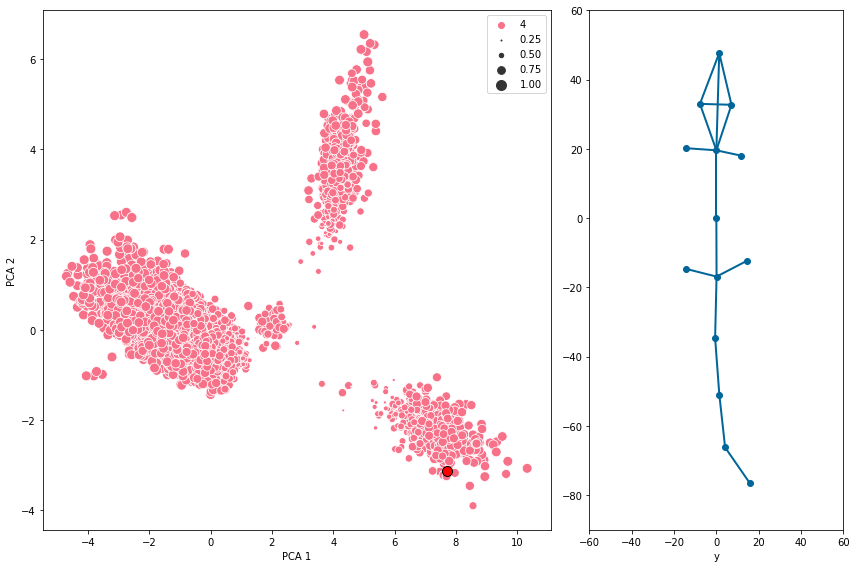

In [30]:
# Plot trajectory of a video in latent space

samples = np.random.choice(range(encodings.shape[0]), 10000)
sample_enc = encodings[samples, :]
sample_grp = groupings[samples, :]
sample_hgr = hard_groups[samples]
k = sample_grp.shape[1]

umap_reducer = umap.UMAP(n_components=2)
pca_reducer = PCA(n_components=2)
tsne_reducer = TSNE(n_components=2)
lda_reducer = LinearDiscriminantAnalysis(n_components=2)

umap_enc = umap_reducer.fit_transform(sample_enc)
pca_enc = pca_reducer.fit_transform(sample_enc)
tsne_enc = tsne_reducer.fit_transform(sample_enc)
try:
    lda_enc = lda_reducer.fit_transform(sample_enc, sample_hgr)
except ValueError:
    warnings.warn(
        "Only one class found. Can't use LDA", DeprecationWarning, stacklevel=2
    )


@interact(
    trajectory=(100, 500), trace=False, dim_red=["PCA", "LDA", "umap", "tSNE"],
)
def plot_dynamic_latent_pace(trajectory, trace, dim_red):

    global sample_enc, sample_grp, sample_hgr

    if dim_red == "umap":
        enc = umap_enc
    elif dim_red == "LDA":
        enc = lda_enc
    elif dim_red == "PCA":
        enc = pca_enc
    else:
        enc = tsne_enc

    traj_enc = enc[:trajectory, :]
    traj_grp = enc[:trajectory, :]
    traj_hgr = enc[:trajectory]

    # Define two figures arranged horizontally
    fig, (ax, ax2) = plt.subplots(
        1, 2, figsize=(12, 8), gridspec_kw={"width_ratios": [3, 1.5]}
    )

    # Plot the animated embedding trajectory on the left
    sns.scatterplot(
        x=enc[:, 0],
        y=enc[:, 1],
        hue=sample_hgr,
        size=np.max(sample_grp, axis=1),
        sizes=(1, 100),
        palette=sns.color_palette("husl", len(set(sample_hgr))),
        ax=ax,
    )

    traj_init = traj_enc[0, :]
    scatter = ax.scatter(
        x=[traj_init[0]], y=[traj_init[1]], s=100, color="red", edgecolor="black"
    )
    (lineplt,) = ax.plot([traj_init[0]], [traj_init[1]], color="red", linewidth=2.0)
    tracking_line_x = []
    tracking_line_y = []

    # Plot the initial data (before feeding it to the encoder) on the right
    edges = deepof.utils.connect_mouse_topview()

    for bpart in exclude_bodyparts:
        if bpart:
            edges.remove_node(bpart)

    for limb in ["Left_fhip", "Right_fhip", "Left_bhip", "Right_bhip"]:
        edges.remove_edge("Center", limb)
        if ("Tail_base", limb) in list(edges.edges()):
            edges.remove_edge("Tail_base", limb)

    edges = edges.edges()

    inv_coords = coords._scaler.inverse_transform(data_prep)[:, window_size // 2, :]
    data = pd.DataFrame(inv_coords, columns=coords[random_exp].columns)

    data["Center", "x"] = 0
    data["Center", "y"] = 0

    init_x = data.xs("x", level=1, axis=1, drop_level=False).iloc[0, :]
    init_y = data.xs("y", level=1, axis=1, drop_level=False).iloc[0, :]

    plots = plot_mouse_graph(init_x, init_y, ax2, edges)
    track = ax2.scatter(x=np.array(init_x), y=np.array(init_y), color="#006699",)

    # Update data in both plots
    def animation_frame(i):
        # Update scatter plot
        offset = traj_enc[i, :]

        prev_t = scatter.get_offsets()[0]

        if trace:
            tracking_line_x.append([prev_t[0], offset[0]])
            tracking_line_y.append([prev_t[1], offset[1]])
            lineplt.set_xdata(tracking_line_x)
            lineplt.set_ydata(tracking_line_y)

        scatter.set_offsets(np.c_[np.array(offset[0]), np.array(offset[1])])

        x = data.xs("x", level=1, axis=1, drop_level=False).iloc[i, :]
        y = data.xs("y", level=1, axis=1, drop_level=False).iloc[i, :]
        track.set_offsets(np.c_[np.array(x), np.array(y)])
        update_mouse_graph(x, y, plots, edges)

        return scatter

    animation = FuncAnimation(
        fig, func=animation_frame, frames=trajectory, interval=75,
    )

    ax.set_xlabel("{} 1".format(dim_red))
    ax.set_ylabel("{} 2".format(dim_red))

    ax2.set_xlabel("x")
    ax2.set_xlabel("y")
    ax2.set_ylim(-90, 60)
    ax2.set_xlim(-60, 60)

    plt.tight_layout()

    video = animation.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()

### 6. Sample from latent space (to be incorporated into deepof.evaluate)

In [ ]:
# Get prior distribution

means = prior.components_distribution.mean().numpy()
stddevs = prior.components_distribution.stddev().numpy()

samples = []
for i in range(means.shape[0]):
    samples.append(
        np.random.normal(means[i, :], stddevs[i, :], size=(500, means.shape[1]))
    )
samples = np.concatenate(samples)
decodings = decoder.predict(samples)

umap_reducer = umap.UMAP(n_components=2)
pca_reducer = PCA(n_components=2)
tsne_reducer = TSNE(n_components=2)
lda_reducer = LinearDiscriminantAnalysis(n_components=2)

umap_enc = umap_reducer.fit_transform(samples)
pca_enc = pca_reducer.fit_transform(samples)
tsne_enc = tsne_reducer.fit_transform(samples)
lda_enc = lda_reducer.fit_transform(samples, np.repeat(range(means.shape[0]), 500))


@interact(dim_red=["PCA", "LDA", "umap", "tSNE"], selected_cluster=(1, k))
def sample_from_prior(dim_red, selected_cluster):

    if dim_red == "umap":
        sample_enc = umap_enc
    elif dim_red == "LDA":
        sample_enc = lda_enc
    elif dim_red == "PCA":
        sample_enc = pca_enc
    else:
        sample_enc = tsne_enc

    fig, (ax, ax2) = plt.subplots(
        1, 2, figsize=(12, 8), gridspec_kw={"width_ratios": [3, 1.5]}
    )

    hue = np.repeat(range(means.shape[0]), 500)

    # Plot the animated embedding trajectory on the left
    sns.scatterplot(
        x=sample_enc[:, 0],
        y=sample_enc[:, 1],
        hue=hue,
        palette=sns.color_palette("husl", k),
        ax=ax,
    )

    sns.kdeplot(
        sample_enc[hue == selected_cluster, 0],
        sample_enc[hue == selected_cluster, 1],
        color="red",
        ax=ax,
    )

    # Get reconstructions from samples of a given cluster
    decs = decodings[hue == selected_cluster][np.random.randint(0, 500, 5)]

    # Plot the initial data (before feeding it to the encoder) on the right
    edges = deepof.utils.connect_mouse_topview()

    for bpart in exclude_bodyparts:
        if bpart:
            edges.remove_node(bpart)

    for limb in ["Left_fhip", "Right_fhip", "Left_bhip", "Right_bhip"]:
        edges.remove_edge("Center", limb)
        if ("Tail_base", limb) in list(edges.edges()):
            edges.remove_edge("Tail_base", limb)

    edges = edges.edges()

    inv_coords = coords._scaler.inverse_transform(decs).reshape(
        decs.shape[0] * decs.shape[1], decs.shape[2]
    )
    data = pd.DataFrame(inv_coords, columns=coords[random_exp].columns)

    data["Center", "x"] = 0
    data["Center", "y"] = 0

    init_x = data.xs("x", level=1, axis=1, drop_level=False).iloc[0, :]
    init_y = data.xs("y", level=1, axis=1, drop_level=False).iloc[0, :]

    plots = plot_mouse_graph(init_x, init_y, ax2, edges)
    track = ax2.scatter(x=np.array(init_x), y=np.array(init_y), color="#006699",)

    # Update data in both plots
    def animation_frame(i):
        # Update scatter plot

        x = data.xs("x", level=1, axis=1, drop_level=False).iloc[i, :]
        y = data.xs("y", level=1, axis=1, drop_level=False).iloc[i, :]
        track.set_offsets(np.c_[np.array(x), np.array(y)])
        update_mouse_graph(x, y, plots, edges)

    animation = FuncAnimation(
        fig, func=animation_frame, frames=5 * window_size, interval=50,
    )

    # Plot samples as video on the right

    ax.set_xlabel("{} 1".format(dim_red))
    ax.set_ylabel("{} 2".format(dim_red))
    ax.get_legend().remove()

    ax2.set_xlabel("x")
    ax2.set_xlabel("y")
    ax2.set_ylim(-90, 60)
    ax2.set_xlim(-60, 60)

    plt.tight_layout()
    
    video = animation.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()